# PCA and Hierarchical Portfolio Optimisation

Correlation is a very fundamental and viseral way of understanding how the stock market works and how strategies perform. Modern portfolio theory has made great progress in tying together stock data with portfolio selection. Today, we’re going to explore how the eigendecomposition of the returns covariance matrix could help you invest. Then later we will perform Hierarchical clustering method to cluster each stocks in out porfolio into groups.  

To demonstrate our idea we are going to use NASDAQ index as the benchmark and create an eigen portfolio using its constituent stocks.

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
import matplotlib.cm as cm
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [16, 10]
np.set_printoptions(precision=5, suppress=True,formatter={'float': lambda x: f'{x:6.3f}'})
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab

import warnings
warnings.filterwarnings('ignore')

Scrape wikipedia page to get the component names and tickers of NASDAQ 100 index for grabbing data.

In [2]:
dow_tab = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
dow_tab

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,ADP,ADP,Information Technology,Data Processing & Outsourced Services
3,Airbnb,ABNB,Consumer Discretionary,Internet & Direct Marketing Retail
4,Align Technology,ALGN,Health Care,Health Care Supplies
...,...,...,...,...
97,Walgreens Boots Alliance,WBA,Consumer Staples,Drug Retail
98,"Workday, Inc.",WDAY,Information Technology,Application Software
99,Xcel Energy,XEL,Utilities,Multi-Utilities
100,Zoom Video Communications,ZM,Information Technology,Application Software


In [3]:
tickers = dow_tab.Ticker.to_list()
bench_sym = ['^NDX']
tickers = tickers + bench_sym
tickers

['ATVI',
 'ADBE',
 'ADP',
 'ABNB',
 'ALGN',
 'GOOGL',
 'GOOG',
 'AMZN',
 'AMD',
 'AEP',
 'AMGN',
 'ADI',
 'ANSS',
 'AAPL',
 'AMAT',
 'ASML',
 'AZN',
 'TEAM',
 'ADSK',
 'BIDU',
 'BIIB',
 'BKNG',
 'AVGO',
 'CDNS',
 'CHTR',
 'CTAS',
 'CSCO',
 'CTSH',
 'CMCSA',
 'CEG',
 'CPRT',
 'COST',
 'CRWD',
 'CSX',
 'DDOG',
 'DXCM',
 'DOCU',
 'DLTR',
 'EBAY',
 'EA',
 'EXC',
 'FAST',
 'FISV',
 'FTNT',
 'GILD',
 'HON',
 'IDXX',
 'ILMN',
 'INTC',
 'INTU',
 'ISRG',
 'JD',
 'KDP',
 'KLAC',
 'KHC',
 'LRCX',
 'LCID',
 'LULU',
 'MAR',
 'MRVL',
 'MTCH',
 'MELI',
 'META',
 'MCHP',
 'MU',
 'MSFT',
 'MRNA',
 'MDLZ',
 'MNST',
 'NTES',
 'NFLX',
 'NVDA',
 'NXPI',
 'ORLY',
 'OKTA',
 'ODFL',
 'PCAR',
 'PANW',
 'PAYX',
 'PYPL',
 'PEP',
 'PDD',
 'QCOM',
 'REGN',
 'ROST',
 'SGEN',
 'SIRI',
 'SWKS',
 'SPLK',
 'SBUX',
 'SNPS',
 'TMUS',
 'TSLA',
 'TXN',
 'VRSN',
 'VRSK',
 'VRTX',
 'WBA',
 'WDAY',
 'XEL',
 'ZM',
 'ZS',
 '^NDX']

In [4]:
start = "2015-01-01"
df = pd.DataFrame()
for stock_name in tickers:
    # daily data
    df[stock_name] = yf.download(stock_name,start)['Adj Close']  
    
df = round(df,2) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## EDA and Pre Processing Data

In [5]:
df= df.dropna(axis=1)   # Drop nan values from our dataframe 
df

,ATVI,ADBE,ADP,ALGN,GOOGL,GOOG,AMZN,AMD,AEP,AMGN,...,TMUS,TSLA,TXN,VRSN,VRSK,VRTX,WBA,WDAY,XEL,^NDX
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,19.07,72.70,70.76,55.91,26.53,26.25,15.52,2.67,46.84,129.54,...,26.94,44.48,43.95,57.00,62.60,118.80,61.66,81.61,28.54,4236.28
2015-01-02,19.06,72.34,70.69,56.20,26.48,26.17,15.43,2.67,47.17,130.03,...,27.30,43.86,43.96,57.19,62.52,123.07,61.50,80.41,28.70,4230.24
2015-01-05,18.79,71.98,70.64,56.99,25.97,25.62,15.11,2.66,46.48,128.49,...,26.93,42.02,43.27,56.24,61.71,121.03,60.29,80.01,28.38,4160.96
2015-01-06,18.44,70.53,70.05,57.45,25.33,25.03,14.76,2.63,46.74,124.35,...,26.87,42.26,42.56,55.18,61.49,117.36,60.44,79.42,28.53,4110.83
2015-01-07,18.04,71.11,70.66,59.57,25.26,24.99,14.92,2.58,47.40,128.69,...,28.25,42.19,43.32,55.64,61.53,120.66,61.99,79.35,28.78,4160.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,79.65,391.96,218.38,252.07,107.51,108.21,121.14,87.54,95.80,248.72,...,134.56,805.30,163.20,181.44,182.77,283.68,38.75,145.44,69.46,12328.41
2022-07-26,79.46,379.26,217.91,251.86,105.02,105.44,114.81,85.25,96.42,251.14,...,133.91,776.58,160.84,177.28,183.01,288.22,38.85,140.91,70.21,12086.90
2022-07-27,79.79,392.78,234.04,262.61,113.06,113.60,120.97,89.82,96.29,251.72,...,140.91,824.46,171.54,181.39,184.53,286.99,39.22,150.10,70.25,12601.47


In [6]:
# Copying the dataframe to add features
data = pd.DataFrame(df.copy())
# Daily Returns
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 

# Daily Linear Returns (%)
datareturns = data.pct_change(1)

# Nasdaq 100 index RETURN
datareturns["^NDX"] = datareturns.mean(axis=1)

# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

# Normalizing the returns
data = (data_raw - data_raw.mean()) / data_raw.std()

# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)

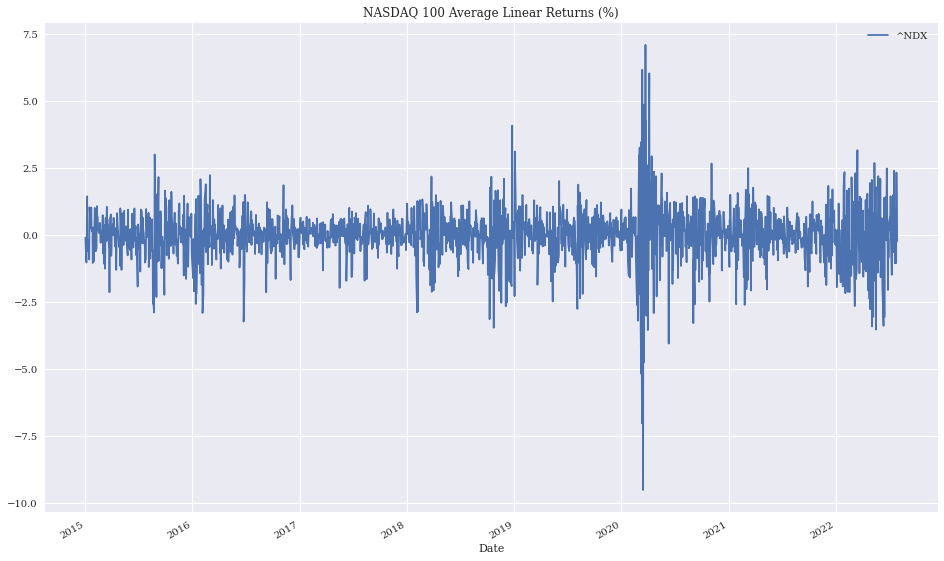

In [7]:
# Visualizing Log Returns for the DJIA 
plt.figure(figsize=(16, 10))
plt.title("NASDAQ 100 Average Linear Returns (%)")
data['^NDX'].plot()
plt.legend()
plt.show()

In [8]:
# Taking away the market benchmark DJIA
stock_tickers = data.columns.values[:-1]
n_tickers = len(stock_tickers)

# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.8)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]

# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != '^NDX'].cov()
pca = PCA()
pca.fit(cov_matrix)

PCA()

## Eigen Portfolio:

Since the covariance matrix is similar by definition to the correlation matrix (in the sense of a linear transformation similarity), the eigenvalues will be the same and the eigenvectors (which we are interested in) have a 1-1 correspondence between them, assuming none of the variances for any of the stocks are equal to 0.

The covariance matrix has some nice properties in the case of stock returns. First of all, it is a symmetric matrix, and so its eigenvalues are positive and its eigenvectors are orthogonal to each other. The typical interpretation of the eigenvalue decomposition of a covariance matrix is this:
- The eigenvalues give the “variance” of each “factor” or eigenvector
- The variance associated with each factor is “uncovariated” with the others (If we use the correlation matrix, this would be   uncorrelated.)

I put the words above in quotes because this is meaningless until you connect it to where the matrix came from. Here, we know loosely that each eigenvalue corresponds to the risk of a portfolio and that the eigenvectors can represent an allocation of weights. So in this context, we can make the interpretations:
- Eigenvectors are the “eigenportfolios”, strategy weight allocations which are uncorrolated to other eigenportfolios
- Eigenvalues are the “risk” of the given eigenportfolio

40 principal components explain 95.00% of variance


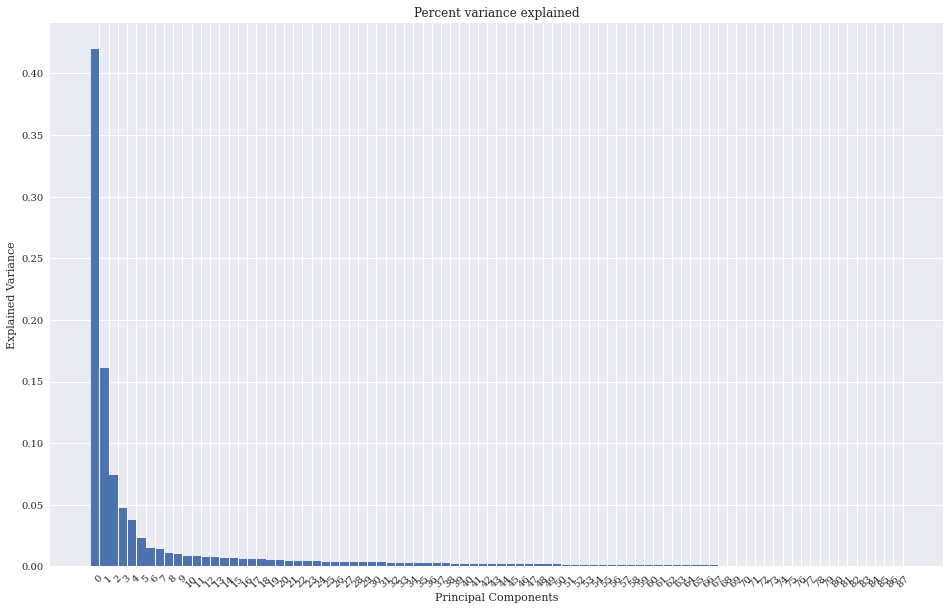

In [9]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != '^NDX'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [10]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

Now we build eigen porfolio based on markowitz pricipals by allocating weightes based on PCA analysis done above.  We use definition of eigen portfolios as provided by Avellaneda http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf

Following Avellaneda we define eigen portfolio weights as:
                                $ {Q_i}^j =  {v_i^j} /{\sigma_i} $
where $ j $ is the index of eigen portfolio and $i$ is the i-th element of j-th eigen vector.



In [11]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #0 with the highest Sharpe. Return nan%, vol = 286.02%, Sharpe = nan
      Return       Vol    Sharpe
83  3.291514  1.983641  1.659329
61  0.884640  0.628070  1.408506
4   0.440779  0.339875  1.296886
67  0.334996  0.258602  1.295413
73  0.429105  0.347700  1.234125
42  0.205243  0.240230  0.854363
87  0.281984  0.343810  0.820174
37  0.249237  0.325609  0.765450
22  0.399458  0.529415  0.754527
70  0.201409  0.271449  0.741977


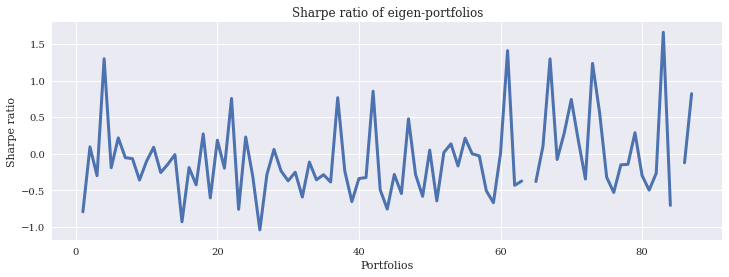

In [12]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


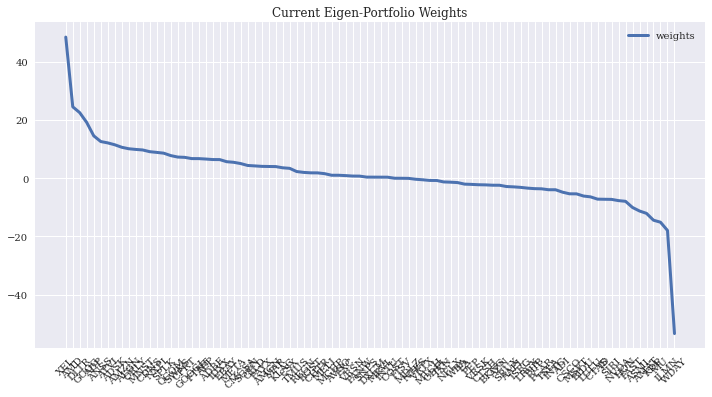

,weights
XEL,48.505381
AMD,24.544945
DLTR,22.522659
GOOG,19.144400
ADP,14.565994
...,...
AMAT,-12.077387
KDP,-14.423940
MU,-15.114519
ILMN,-17.949550


In [13]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

Current Eigen-Portfolio:
Return = 44.08%
Volatility = 33.99%
Sharpe = 1.30


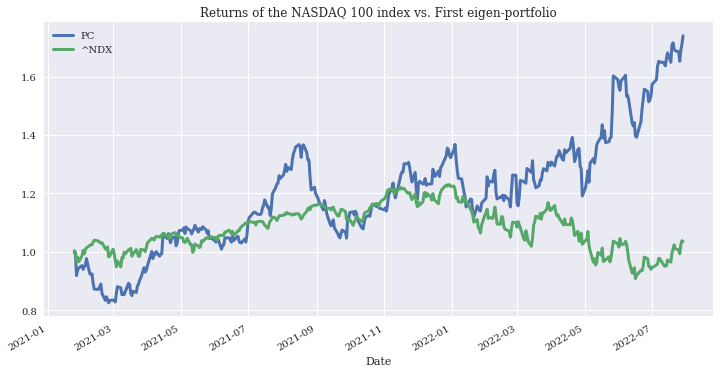

In [15]:
def plotSharpe(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''

    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns, '^NDX': X_test_raw.loc[:, '^NDX']}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the NASDAQ 100 index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))

## Investigating Hierarchical Clustering

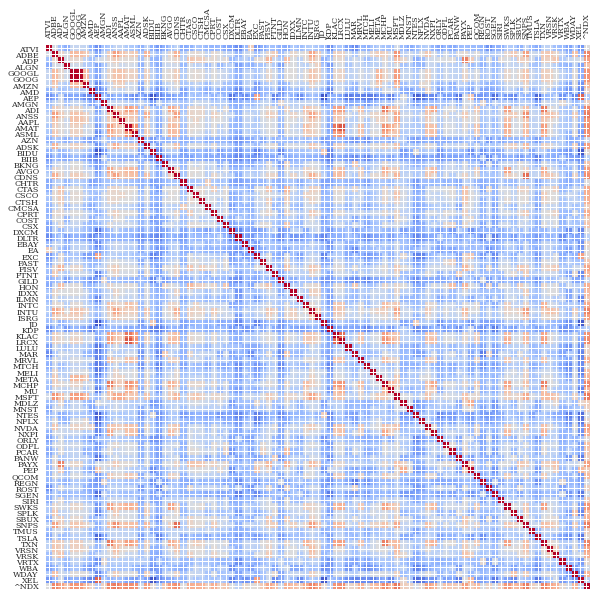

In [16]:
#find correlation matrix, i.e. the "distances" between each stock
corr = data.corr()
size = 10
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);

### Clusters of Correlation - Agglomerate:

The next step is to look for clusters of correlations using the agglomerate hierarchical clustering technique. Its primary advantage over other clustering methods is that you don't need to guess in advance how many clusters there might be. Agglomerate Clustering first assigns each data point into its own cluster, and gradually merges clusters until only one remains. It's then up to the user to choose a cutoff threshold and decide how many clusters are present.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

There are also different options for the measurement of the distance. The option we will choose is the average distance measurement, but others are possible (ward, single, centroid, etc.).

In [18]:
Z = linkage(corr, 'average')
Z[0]

array([ 4.000,  5.000,  0.045,  2.000])

### Cophenetic Correlation coefficient:
It's important to get a sense of how well the clustering performs. One measure is the Cophenetic Correlation Coefficient, c. This compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer c is to 1, the better the clustering preserves the original distances. Generally c > 0.7 is consistered a good cluster fit. Of course, other accuracy checks are possible.

In [19]:
c, coph_dists = cophenet(Z, pdist(corr))
c

0.6661492682372363

### Dendogram:

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

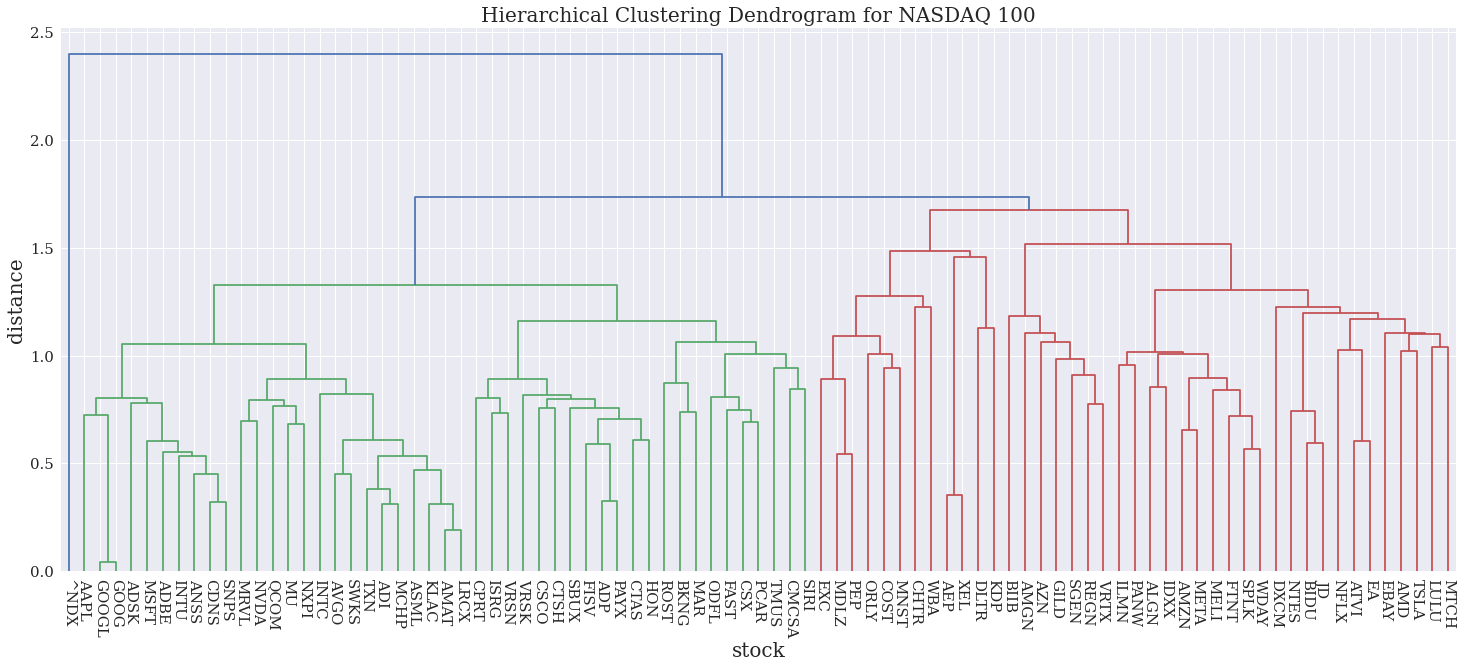

In [20]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for '+"NASDAQ 100", fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.savefig('dendogram_'+'NASDAQ 100'+'.png')
plt.show()

According to the dendogram above, the two most correlated stocks are GOOG and GOOGL. That is they are both shares of same company, so it makes sense that they would be strongly correlated. Let's plot them below to visually see how well they correlate. In addition, let's pick two stocks that are not well correlated at all to compare to, say, Apple and Tesla .

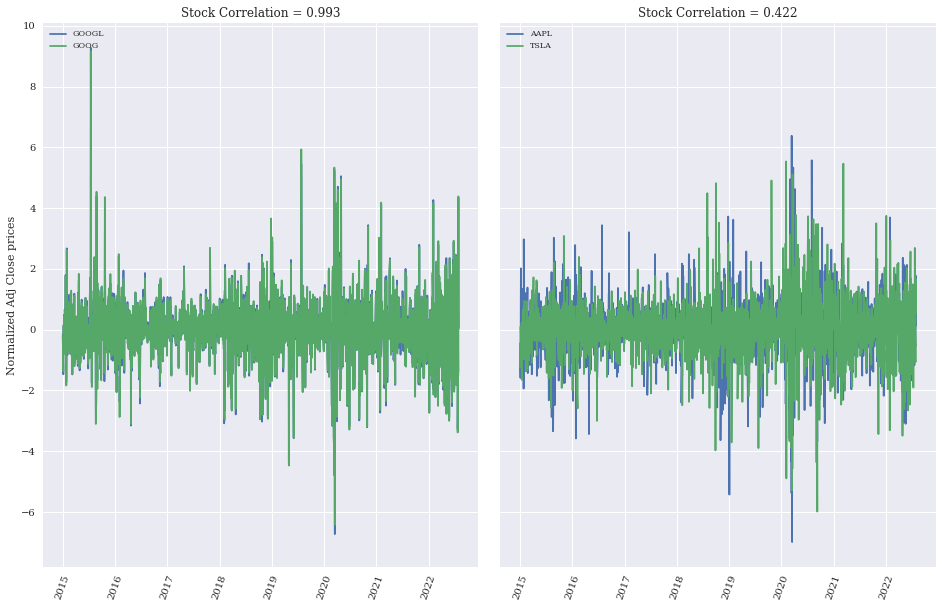

In [21]:
#plot sample correlations
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), sharey=True)
plt.subplots_adjust(wspace=0.05)

#high correlation
sA = "GOOGL"
sB = "GOOG"
ax1.plot(data[sA],label=sA)
ax1.plot(data[sB],label=sB)
ax1.set_title('Stock Correlation = %.3f'%corr[sA][sB])
ax1.set_ylabel('Normalized Adj Close prices')
ax1.legend(loc='upper left',prop={'size':8})
plt.setp(ax1.get_xticklabels(), rotation=70);

#low correlation
sA = "AAPL"
sB = "TSLA"
ax2.plot(data[sA],label=sA)
ax2.plot(data[sB],label=sB)
ax2.set_title('Stock Correlation = %.3f'%corr[sA][sB])
ax2.legend(loc='upper left',prop={'size':8})
plt.setp(ax2.get_xticklabels(), rotation=70);

We can eyeball it that the google stocks are very highly correlated to each other whereas Apple and Tesla show low correlation compared to google.